# get the data from the files

In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path("/home/kent/college/data_sets/dogs-vs-cats/train")
new_base_dir = pathlib.Path("/home/kent/college/data_sets/dogs-vs-cats/cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

# Data preprocessing

Using image_dataset_from_directory to read images

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Leveraging a pretrained model

Feature extraction with a pretrained model

Instantiating the VGG16 convolutional base

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

2022-03-12 20:47:42.378755: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-12 20:47:42.380272: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kent-5040): /proc/driver/nvidia/version does not exist
2022-03-12 20:47:42.386982: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

Fast feature extraction without data augmentation

Extracting the VGG16 features and corresponding labels

In [42]:
import numpy as np

def get_features_and_labels(dataset, return_images=False):
    all_features = []
    all_labels = []
    all_images = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
        if return_images:
            all_images.append(images)
    if return_images:
        return np.concatenate(all_features), np.concatenate(all_labels), np.concatenate(all_images)
    else:
        return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels, train_images =  get_features_and_labels(train_dataset, return_images=True)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 1s/step


In [43]:
train_features.shape

(2000, 5, 5, 512)

In [73]:
train_labels[:6]

array([1, 0, 1, 1, 1, 0], dtype=int32)

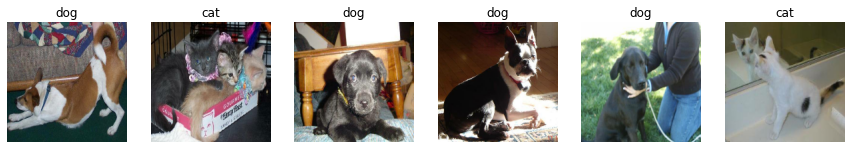

In [93]:
class_names = train_dataset.class_names
plt.figure(figsize=(15, 15))
for i in range(6):
    ax = plt.subplot(1, 6, i+1)
    plt.imshow(train_images[i].astype("uint8"))
    plt.title(class_names[train_labels[i]])
    plt.axis("off")


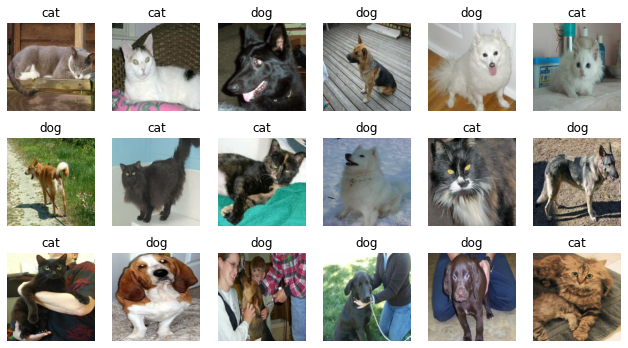

In [91]:
plt.figure(figsize=(11, 6))
class_names = train_dataset.class_names
for images, labels in train_dataset:
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break

Defining and training the densely connected classifier

In [11]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 31ms/step - loss: 11.5484 - accuracy: 0.9300 - val_loss: 2.7224 - val_accuracy: 0.9750
Epoch 2/20
63/63 [==============================] - 2s 27ms/step - loss: 3.6403 - accuracy: 0.9765 - val_loss: 5.4839 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 2s 30ms/step - loss: 2.0811 - accuracy: 0.9835 - val_loss: 5.4154 - val_accuracy: 0.9690
Epoch 4/20
63/63 [==============================] - 2s 30ms/step - loss: 1.7273 - accuracy: 0.9875 - val_loss: 6.0997 - val_accuracy: 0.9670
Epoch 5/20
63/63 [==============================] - 2s 27ms/step - loss: 0.8509 - accuracy: 0.9900 - val_loss: 4.7459 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 2s 32ms/step - loss: 0.7101 - accuracy: 0.9930 - val_loss: 3.7834 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 2s 27ms/step - loss: 0.6301 - accuracy: 0.9930 - val_loss: 3.8050 - val_accuracy: 0.9770
Epoch 8/20
6

Plotting the results

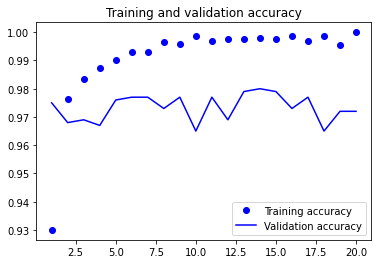

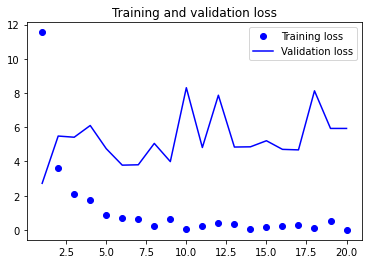

In [12]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We reach a validation accuracy of about 97%—much better than we achieved in the
previous section with the small model trained from scratch. This is a bit of an unfair
comparison, however, because ImageNet contains many dog and cat instances, which
means that our pretrained model already has the exact knowledge required for the
task at hand. This won’t always be the case when you use pretrained features.
However, the plots also indicate that we’re overfitting almost from the start—
despite using dropout with a fairly large rate. That’s because this technique doesn’t
use data augmentation, which is essential for preventing overfitting with small image
datasets

# Feature extraction together with data augmentation
## Instantiating and freezing the VGG16 convolutional base

In [95]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Printing the list of trainable weights before and after freezing

In [96]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [98]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a data augmentation stage and a classifier to the convolutional base

In [99]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [100]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 206s 3s/step - loss: 16.3269 - accuracy: 0.9070 - val_loss: 7.8990 - val_accuracy: 0.9510
Epoch 2/50
63/63 [==============================] - 202s 3s/step - loss: 7.0126 - accuracy: 0.9475 - val_loss: 3.9933 - val_accuracy: 0.9750
Epoch 3/50
 2/63 [..............................] - ETA: 2:15 - loss: 2.7126 - accuracy: 0.9688

KeyboardInterrupt: 

Evaluating the model on the test set

In [101]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 131s 2s/step - loss: 5.0273 - accuracy: 0.9685
Test accuracy: 0.969


# Use the pretrained feaures on another classifier

In [102]:
train_features.shape

(2000, 5, 5, 512)

In [103]:
train_labels.shape

(2000,)

beagle (62.93%)


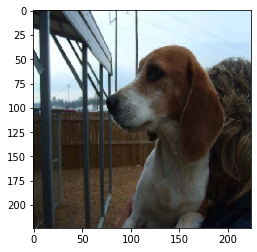

In [107]:

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
# load the model
model = VGG16()
# load an image from file
image = load_img('/home/kent/college/data_sets/dogs-vs-cats/cats_vs_dogs_small/train/dog/dog.465.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
plt.imshow(image.astype("uint8"))
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

Predicted: [('n02101006', 'Gordon_setter', 0.73028), ('n02108551', 'Tibetan_mastiff', 0.21554203), ('n02091635', 'otterhound', 0.019898605)]


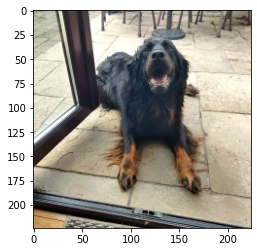

In [115]:
# load an image from file
image = load_img('/home/kent/college/data_sets/scoby/IMG_20200709_192029_224.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
plt.imshow(image.astype("uint8"))
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
print('Predicted:', decode_predictions(yhat, top=3)[0])

# Flatten the VGG model


In [116]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
# x = layers.Dense(256)(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, x)

In [ ]:
model.compile(loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")
]

In [ ]:
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)